Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import warnings
import random
from tensorflow.keras.utils import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

Load the Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!unzip '/content/drive/MyDrive/projects/codeclause/age and gender detection/UTKFace.zip'

Streaming output truncated to the last 5000 lines.
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104204327523.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170105164106036.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170105172720493.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170108224608

In [4]:
BASE_DIR = '/content/UTKFace'
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23707 [00:00<?, ?it/s]

convert to dataframe

In [5]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

image  age  gender
0  /content/UTKFace/31_0_0_20170116210515941.jpg....   31       0
1  /content/UTKFace/12_1_0_20170103200659679.jpg....   12       1
2  /content/UTKFace/35_0_1_20170113150646976.jpg....   35       0
3  /content/UTKFace/43_0_4_20170104205649403.jpg....   43       0
4  /content/UTKFace/26_1_1_20170113011621775.jpg....   26       1

In [6]:
df.describe()

age        gender
count  23707.000000  23707.000000
mean      33.300671      0.477370
std       19.881812      0.499498
min        1.000000      0.000000
25%       23.000000      0.000000
50%       29.000000      0.000000
75%       45.000000      1.000000
max      116.000000      1.000000

In [7]:
df.shape

(23707, 3)

In [8]:
df.head(n=5)

image  age  gender
0  /content/UTKFace/31_0_0_20170116210515941.jpg....   31       0
1  /content/UTKFace/12_1_0_20170103200659679.jpg....   12       1
2  /content/UTKFace/35_0_1_20170113150646976.jpg....   35       0
3  /content/UTKFace/43_0_4_20170104205649403.jpg....   43       0
4  /content/UTKFace/26_1_1_20170113011621775.jpg....   26       1

In [9]:
df.tail(n=5)

image  age  gender
23702  /content/UTKFace/35_1_2_20170117135409365.jpg....   35       1
23703  /content/UTKFace/24_0_4_20170115205946148.jpg....   24       0
23704  /content/UTKFace/16_0_0_20170110231756634.jpg....   16       0
23705  /content/UTKFace/24_0_1_20170113195929797.jpg....   24       0
23706  /content/UTKFace/70_0_0_20170117171117703.jpg....   70       0

In [11]:
gender_dict = {0:'Male', 1:'Female'}
print(gender_dict)

{0: 'Male', 1: 'Female'}


Exploratory Data Analysis

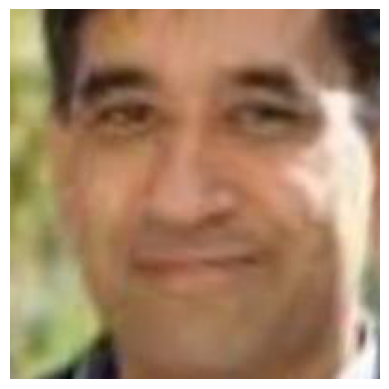

In [12]:
from PIL import Image
img = Image.open(df['image'][3])
plt.axis('off')
plt.imshow(img);

<Axes: xlabel='gender', ylabel='Density'>

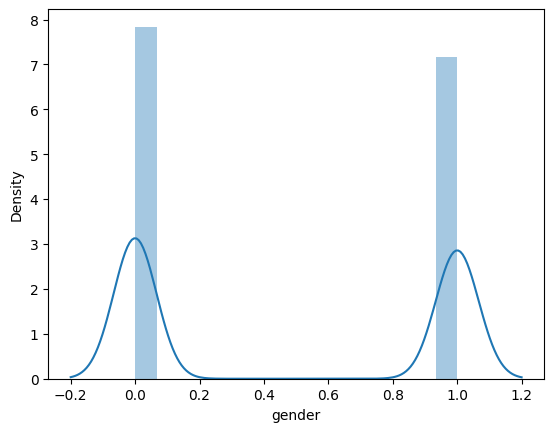

In [13]:
sns.distplot(df['gender'])

<Axes: xlabel='age', ylabel='Density'>

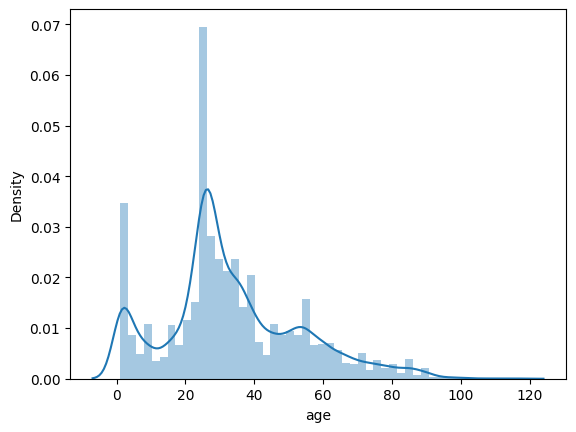

In [14]:
sns.distplot(df['age'])

<Axes: ylabel='count'>

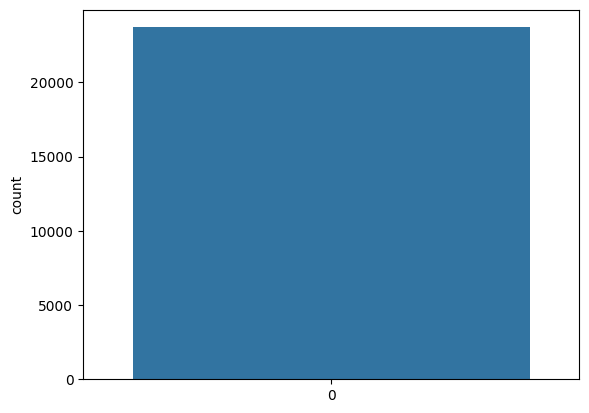

In [15]:
sns.countplot(df['age'])

<Axes: ylabel='count'>

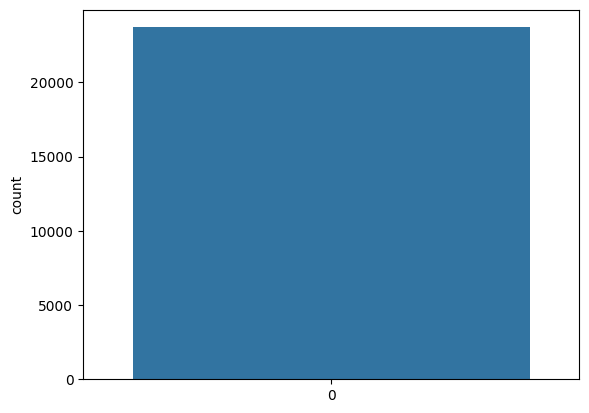

In [16]:
sns.countplot(df['gender'])

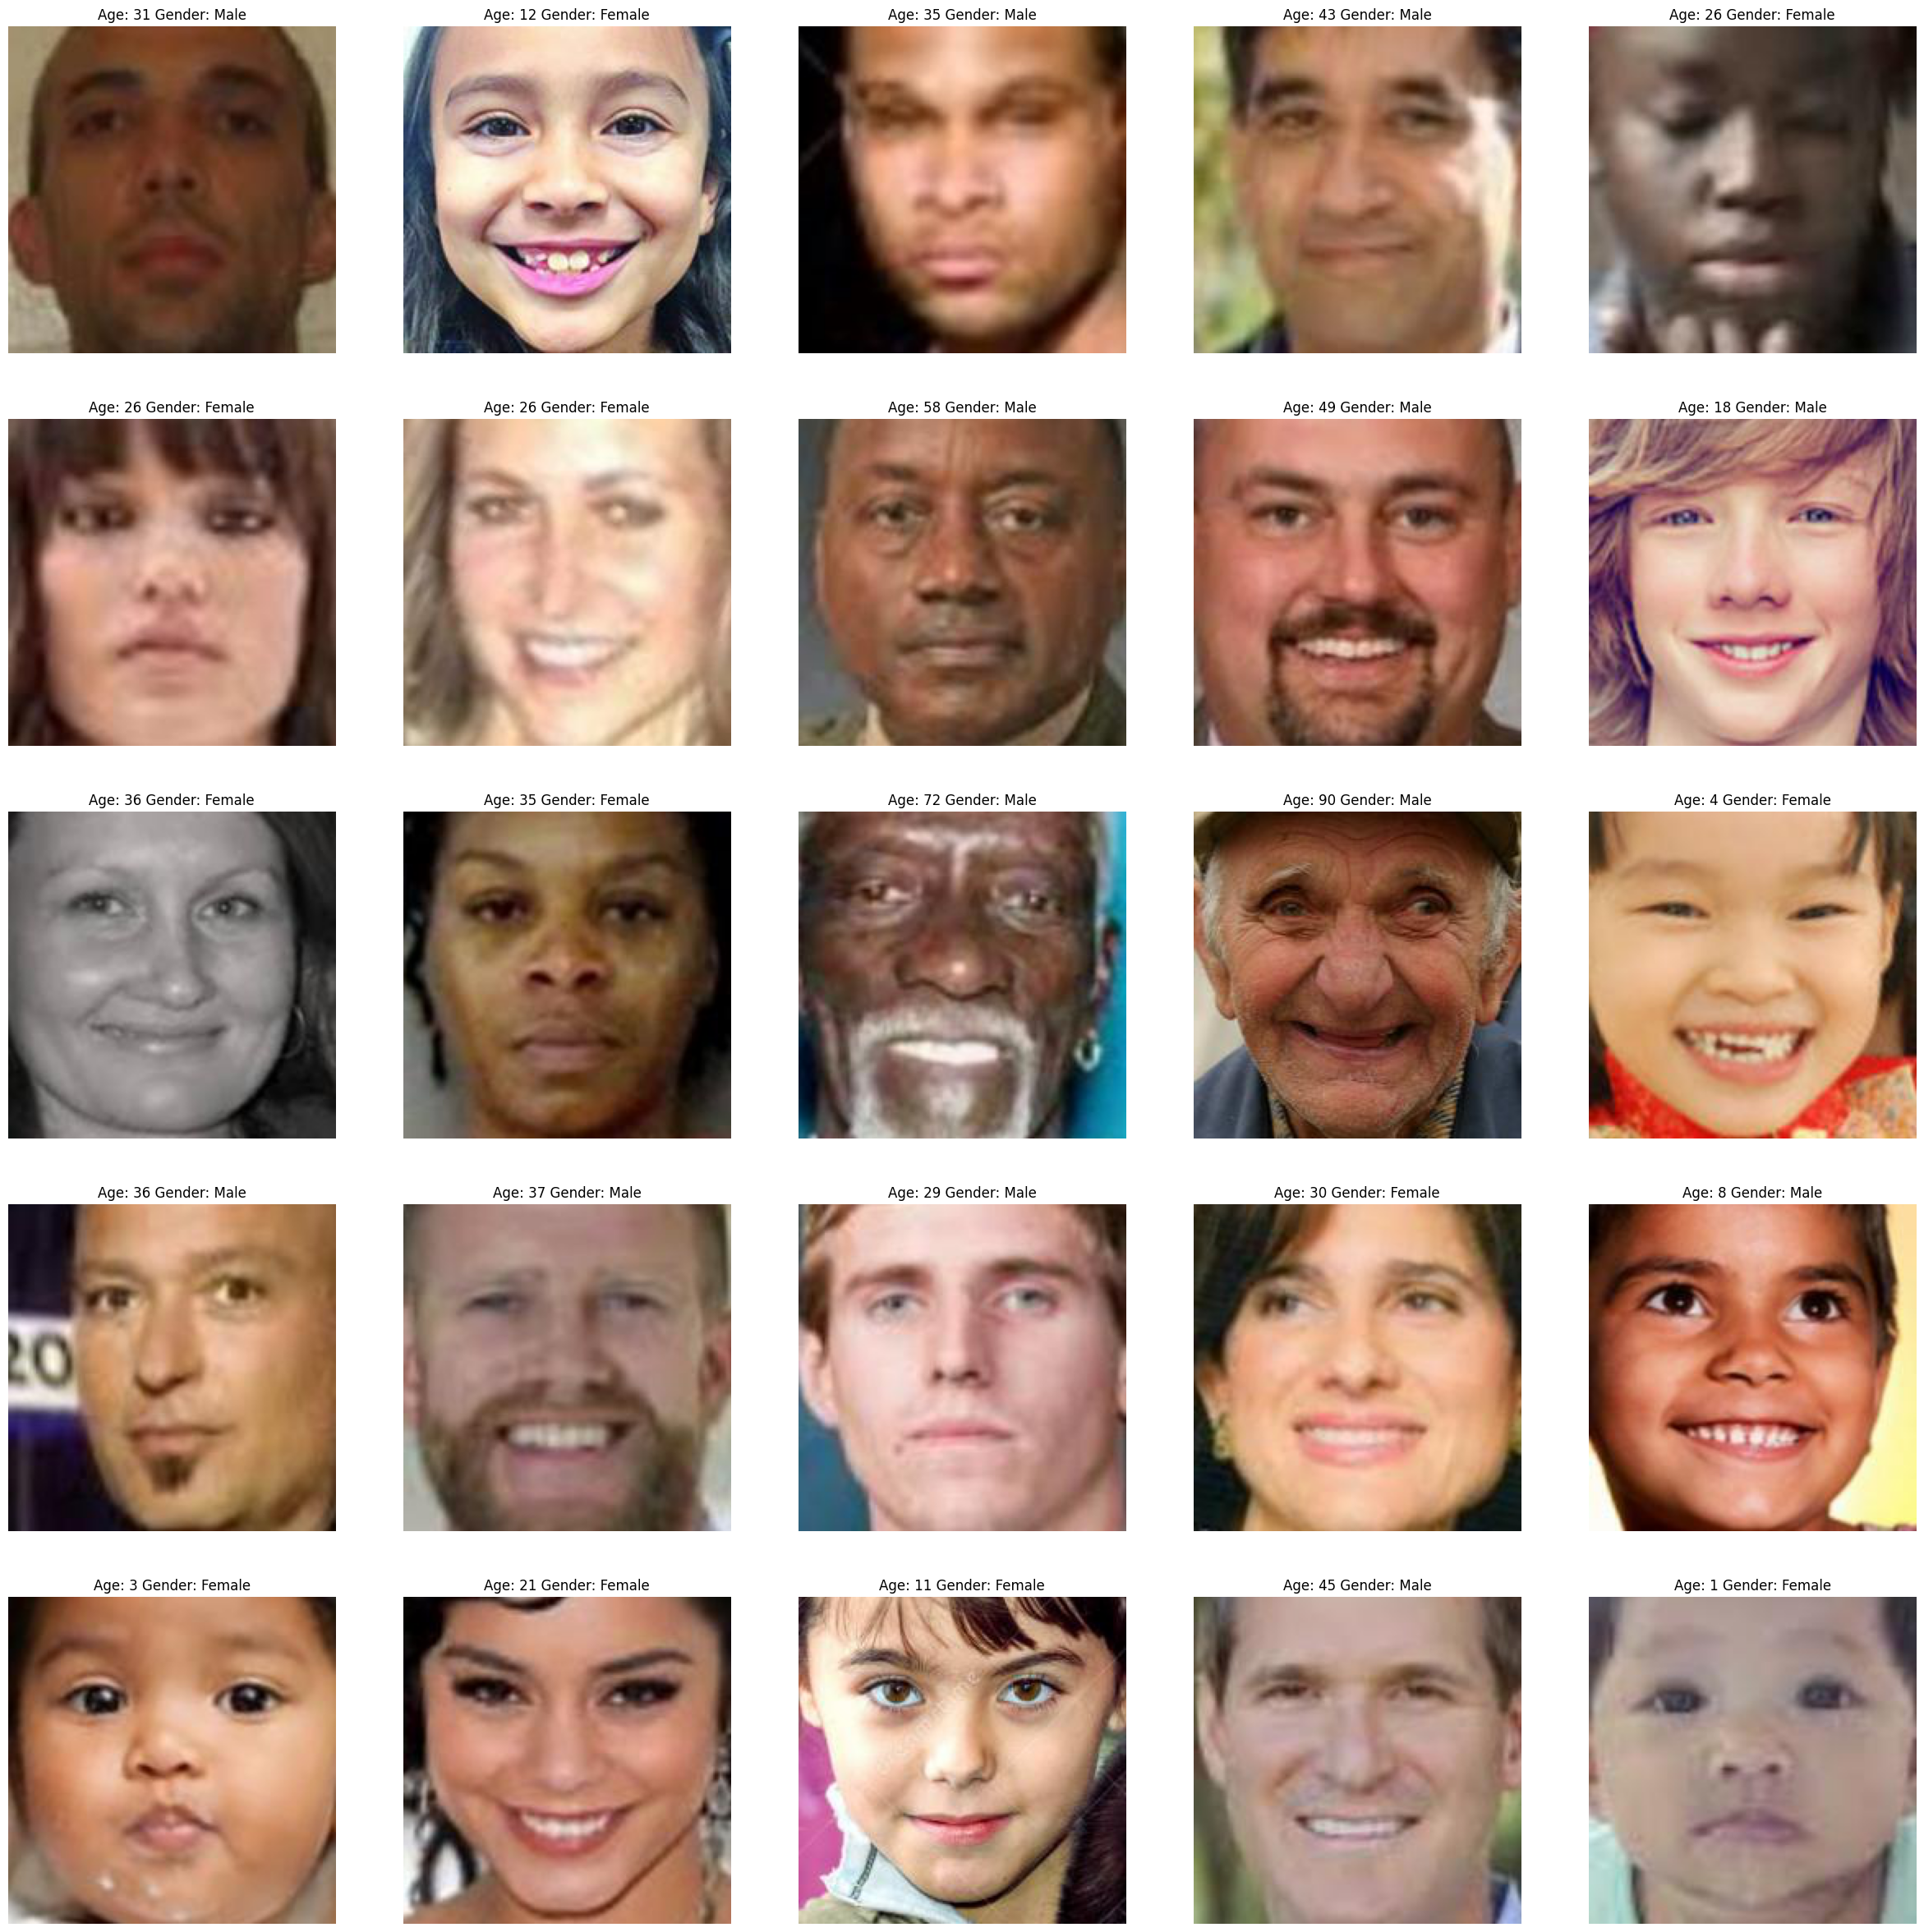

In [17]:
plt.figure(figsize=(30, 30))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

Feature Extraction

In [18]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [19]:
X = extract_features(df['image'])

  0%|          | 0/23707 [00:00<?, ?it/s]

In [20]:
X.shape

(23707, 128, 128, 1)

In [21]:
X = X/255.0

In [22]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [23]:
input_shape = (128, 128, 1)

Model Creation

In [24]:
inputs = Input((input_shape))
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

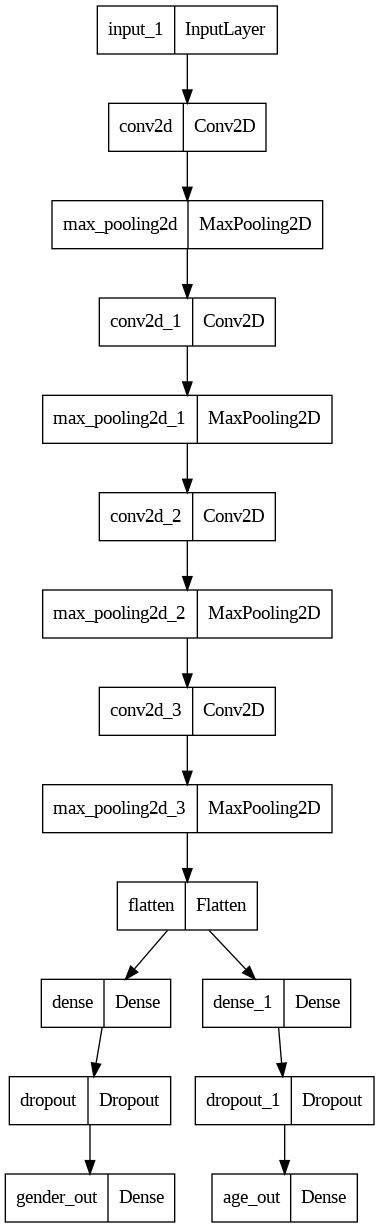

In [25]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [26]:
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=3, validation_split=0.2)

Epoch 1/3
593/593 [==============================] - 921s 2s/step - loss: 15.7819 - gender_out_loss: 0.6891 - age_out_loss: 15.0928 - gender_out_accuracy: 0.5583 - age_out_accuracy: 0.0486 - val_loss: 13.0371 - val_gender_out_loss: 0.5511 - val_age_out_loss: 12.4860 - val_gender_out_accuracy: 0.7185 - val_age_out_accuracy: 0.0424
Epoch 2/3
593/593 [==============================] - 925s 2s/step - loss: 11.8328 - gender_out_loss: 0.5077 - age_out_loss: 11.3252 - gender_out_accuracy: 0.7524 - age_out_accuracy: 0.0374 - val_loss: 10.0293 - val_gender_out_loss: 0.4086 - val_age_out_loss: 9.6207 - val_gender_out_accuracy: 0.8087 - val_age_out_accuracy: 0.0169
Epoch 3/3
593/593 [==============================] - 928s 2s/step - loss: 9.9199 - gender_out_loss: 0.4180 - age_out_loss: 9.5019 - gender_out_accuracy: 0.8051 - age_out_accuracy: 0.0243 - val_loss: 10.4333 - val_gender_out_loss: 0.3996 - val_age_out_loss: 10.0337 - val_gender_out_accuracy: 0.8191 - val_age_out_accuracy: 0.0205


Prediction Result

Original Gender: Male Original Age: 12
1/1 [==============================] - 0s 188ms/step
Predicted Gender: Male Predicted Age: 22


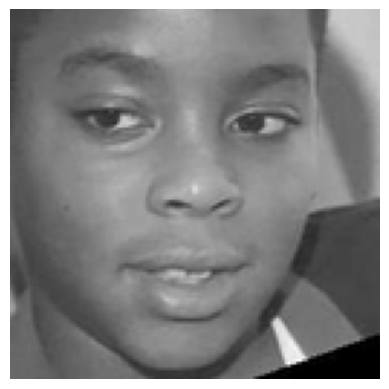

In [29]:
image_index = 50
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 36
1/1 [==============================] - 0s 39ms/step
Predicted Gender: Female Predicted Age: 52


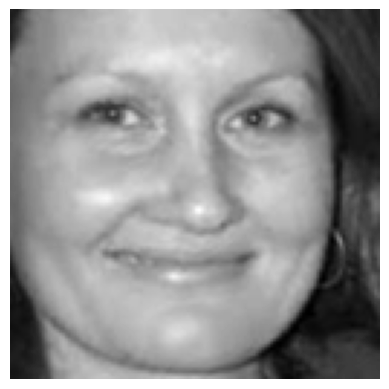

In [30]:
image_index = 10
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');